In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import networkx as nx
import csv
import random
import time
import pystan
import pandas as pd


In [3]:
def logit(z): return 1./(1.+np.exp(-z))

In [21]:
def convert_race(race):
    if race == 'Z':
        return 1
    elif race == 'P':
        return 2
    elif race == 'T':
        return 3
    else:
        return 4
    

def load_data_stan(file_name, pk=1, edge=3, nk=5):
    with open(file_name, encoding='utf-8') as f: lines = f.read().split('\n')
    p = 0; playerid = {};
    for i in range(len(lines)):
        csv = lines[i].split(',')
        if len(csv) != 10: continue   # parse error or blank line
        player0,player1 = csv[1],csv[4]
        if player0 not in playerid: playerid[player0]=p; p+=1
        if player1 not in playerid: playerid[player1]=p; p+=1

    nplayers = len(playerid)
    playername = ['']*nplayers
    for player in playerid:
        playername[ playerid[player] ]=player;  # id to name lookup


    pKeep = pk   # fraction of edges to consider (immed. throw out 1-p edges)
    nEdge = edge     # try to keep nEdge opponents per player (may be more; asymmetric)
    nKeep = nk     # keep at most nKeep games per opponent pairs (play each other multiple times)

    count = 0
    nplays, nwins = np.zeros( (nplayers,nplayers) ), np.zeros( (nplayers,nplayers) );
    player_A = []
    player_B = []
    wins = []
    RA = []
    RB = []
    for i in range(len(lines)):
        csv = lines[i].split(',')
        if len(csv) != 10: continue;   # parse error or blank line
        a,b = playerid[csv[1]],playerid[csv[4]];
        aw,bw = csv[2]=='[winner]',csv[5]=='[winner]';
        if (np.random.rand() < pKeep):
            if (nplays[a,b] < nKeep) and ( ((nplays[a,:]>0).sum() < nEdge) or ((nplays[:,b]>0).sum() < nEdge) ):
                count += 1
                nplays[a,b] += 1; nplays[b,a]+=1; nwins[a,b] += aw; nwins[b,a] += bw;
                player_A.append(a+1)
                player_B.append(b+1)
                wins.append(aw)
                RA.append(convert_race(csv[6]))
                RB.append(convert_race(csv[7]))

    win_re = []
    for i in wins:
        if i:
            win_re.append(1)
        else:
            win_re.append(0)
    return player_A,player_B,win_re,RA,RB, playerid, playername

In [28]:

baseline = []
for i in [2,4,8,16,32,64,128,256,512]:
    player_A,player_B,win_re,RA,RB,playerid, playername = load_data_stan("train.csv",1,i,100)
    nplayers = len(set(player_A + player_B))
    print(len(win_re))
    baseline_win_rate = dict()
    record = np.zeros( (nplayers,2) )
    for j in range(len(win_re)):
        record[player_A[j]-1][0] += 1
        record[player_B[j]-1][0] += 1
        if win_re == 1:
            record[player_A[j]-1][1] += 1
        else:
            record[player_B[j]-1][1] += 1
    for k in range(len(record)):
        baseline_win_rate[k] = record[k][1]/record[k][0]
    baseline.append(baseline_win_rate)
    
    
        
    


2998
7462
17233
35709
73619
129106
177857
192804
193006


In [9]:
def load_data(file_name):
    data=pd.read_csv(file_name,index_col=False,
                     names=['date', 'p1', 'p1_outcome', 'score', 'p2', 'p2_outcome', 'p1_race', 'p2_race', 'addon', 'type'])
    #drop other columns for now
    data.drop(columns=['date','score','p2_outcome', 'addon', 'type'], inplace=True)
    data['p1_outcome'].replace({"[loser]":0,"[winner]":1},inplace=True)
    return data

valid_data = load_data('valid.csv')
print(valid_data)
valid_data['p1'].replace(playerid,inplace=True)
valid_data['p2'].replace(playerid,inplace=True)
valid_games=[tuple((r[0],r[2],r[1],r[3],r[4])) for r in valid_data.to_numpy()]
#valid_games

           p1  p1_outcome       p2 p1_race p2_race
0          MC           1  NaTuRal       P       T
1          MC           0     Cure       P       T
2          MC           1  Journey       P       T
3          MC           0    Trust       P       P
4          MC           0  Billowy       P       P
...       ...         ...      ...     ...     ...
94002  Keiras           0   Dragon       Z       T
94003  Keiras           0     nExt       Z       Z
94004  Keiras           0      EJK       Z       T
94005  Keiras           0    DeViL       Z       Z
94006  Keiras           0      HuK       Z       P

[94007 rows x 5 columns]


In [24]:
def validate(baseline, valid_games, n_games):
    accuracy = []
    for d in baseline:
        
        acc = 0
        n = n_games
        #for g in valid_games[:n_games]:
        for g in [valid_games[i] for i in np.random.choice(len(valid_games), n, replace = False)]:
            try:
                i,j,result,ra,rb=int(g[0]),int(g[1]),int(g[2]),convert_race(g[3]),convert_race(g[4])
            except:
                n-=1
                continue
            
            prob = logit( 5*(d[i] - d[j]) )
            pred_simulate = np.random.choice([1,0], p=[prob, 1-prob])
            acc+= (pred_simulate==result)
        accuracy.append(acc/n)
    return accuracy


In [25]:
accuracy = validate(baseline, valid_games, len(valid_games))

In [26]:
accuracy

[0.4318082695969449,
 0.4233089025285351,
 0.4105226206559086,
 0.4109268458731797,
 0.4202878509047199,
 0.4436265384492644,
 0.4684757518057166,
 0.4706032529492485,
 0.47285840416139224]

In [32]:
data_num = [2808,6608,14370,29739,60596,102716,127579]
model_result = [0.5607,0.5772,0.5961,0.6049,0.6091,0.6043,0.6087]
{1: [(0.5487, 0.5391)],
 2: [(0.5927, 0.5607)],
 4: [(0.6217, 0.5772)],
 8: [(0.6497, 0.5961)],
 16: [(0.6671, 0.6049)],
 32: [(0.6828, 0.6091)],
 64: [(0.6834, 0.6043)],
 128: [(0.6818, 0.6087)]}

{1: [(0.5487, 0.5391)],
 2: [(0.5927, 0.5607)],
 4: [(0.6217, 0.5772)],
 8: [(0.6497, 0.5961)],
 16: [(0.6671, 0.6049)],
 32: [(0.6828, 0.6091)],
 64: [(0.6834, 0.6043)],
 128: [(0.6818, 0.6087)]}

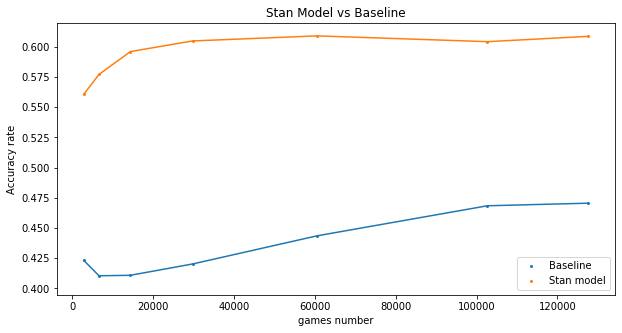

In [36]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
    
       
    
plt.scatter(data_num, accuracy[1:8], marker='.' ,label = 'Baseline',linewidths=0.01)
plt.errorbar(data_num, accuracy[1:8], capsize = 5)
plt.scatter(data_num, model_result, marker='.' ,label = 'Stan model',linewidths=0.01)
plt.errorbar(data_num,  model_result, capsize = 5)
plt.title("Stan Model vs Baseline")
plt.xlabel("games number")
plt.ylabel("Accuracy rate")
plt.legend()
plt.show()